# Homework 3

## Problem 1

Data:	
HJAndrews_peakflow_WS1_WS2_WS3.xlsx

For this problem, consider only differences between WS1 and WS2. These two watersheds are adjacent to each other, and we expect they experience the same storms leading to peak runoff. WS2 is the control, but WS1 was actively 100% clearcut from late 1962 to 1966. Here we want to test whether the difference in peak flows between WS1 and WS2 is statistically different in 4 periods (labeled Index12), where 1 indicates the control period pre-treatment, 2 indicates the period of active treatment, 3 indicates the first 15 years post-treatment (when the forest would start to recover), and 4 indicates longer than 15 years post-treatment. We want to know whether the four periods are statistically different from each other, and if so, which one or ones are statistically different from which other ones.

In [1]:
import numpy as np
import scipy.stats as st
from scipy.io import loadmat
import statistics as stats
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


In [2]:
df=pd.read_excel('HJAndrews_peakflow_WS1_WS2_WS3.xlsx')

In [3]:
#rearrage the dataset
df_hja=df[2:].copy()
df_hja.columns=['year','WS1','WS2','WS3','I12','I23']
df_hja.head()

,year,WS1,WS2,WS3,I12,I23
2,1953,87.5495,96.0073,81.9364,1,1
3,1954,74.7993,60.2205,50.7975,1,1
4,1955,54.4041,40.5364,35.1773,1,1
5,1956,73.5548,69.7704,54.6327,1,1
6,1957,78.3552,71.5483,57.1218,1,1


A) First, plot the timeseries of peakflow as a function of wateryear for both watershed 1 and watershed 2 on the same graph, with vertical dashed lines to indicate the different periods (put a vertical dashed line in 1963, in 1967, and in 1982).

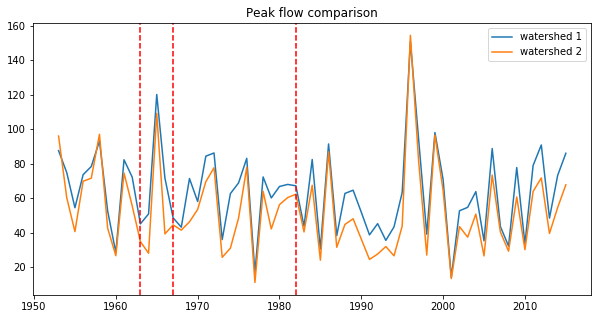

In [4]:
plt.figure(figsize=(10,5))

plt.plot(df_hja['year'],df_hja['WS1'],label='watershed 1')
plt.plot(df_hja['year'],df_hja['WS2'],label='watershed 2')
plt.axvline(1963,linestyle='--',color='red')
plt.axvline(1967,linestyle='--',color='red')
plt.axvline(1982,linestyle='--',color='red')
plt.title('Peak flow comparison')

plt.legend(loc='best')
plt.show()

B) It has been suggested that paired data such as this can be made to be closer to normally distributed by taking the log of each value before subtracting. Create two series: Q12=Peakflow1-Peakflow2; and Qlog12=log(Peakflow1)- log(Peakflow2); and make graphs to demonstrate which is closer to normally distributed. Given that we want to use an ANOVA analysis, why is it important to do a transformation to get the data closer to normally distributed?

In [5]:
#Create columns with the Q12 and Qlog12
df_hja['Q12']=df_hja['WS1']-df_hja['WS2']
df_hja['Qlog12']=np.log(list(df_hja['WS1']))-np.log(list(df_hja['WS2']))
df_hja.head()

,year,WS1,WS2,WS3,I12,I23,Q12,Qlog12
2,1953,87.5495,96.0073,81.9364,1,1,-8.4578,-0.092220
3,1954,74.7993,60.2205,50.7975,1,1,14.5788,0.216796
4,1955,54.4041,40.5364,35.1773,1,1,13.8677,0.294239
5,1956,73.5548,69.7704,54.6327,1,1,3.7844,0.052821
6,1957,78.3552,71.5483,57.1218,1,1,6.8069,0.090880


In [6]:
def pdf_fn(data, nbins):
    counts, bins, patches = plt.hist(data, nbins)
    plt.close()
    width = bins[2]-bins[1]
    centers = bins + width/2
    centers_list = np.array(centers).tolist()
    # Then, remove the last number from the list.
    centers_list.remove(centers_list[len(centers_list)-1])
    areas = [c * width for c in counts]
    area_under_curve = sum(areas)
    fractions = [c / area_under_curve for c in counts]
    return centers_list, fractions

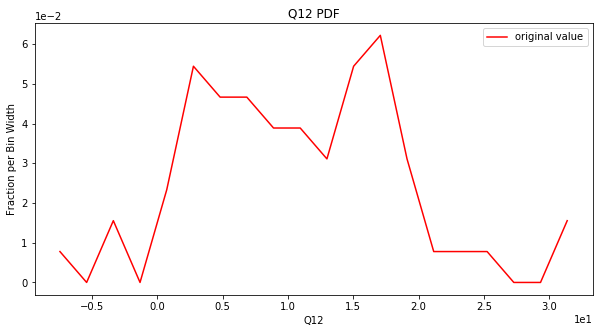

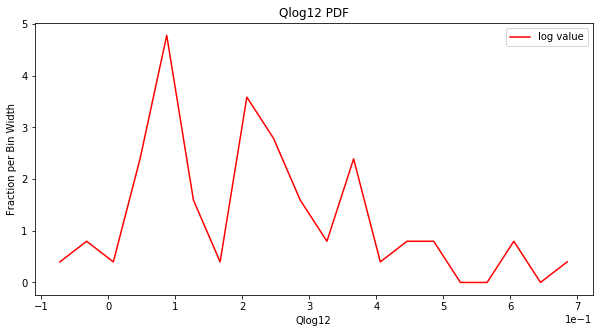

In [7]:
#Create the comparison plot
nbins = 20
#Generate data for the plots,_w for whole period, _b for before, _a for after
cl, frac = pdf_fn(list(df_hja['Q12']), nbins)
cl_log,frac_log = pdf_fn(list(df_hja['Qlog12']), nbins)

plt.figure(1,figsize=(10,5))

plt.plot(cl, frac,'r',linestyle='-',label='original value')
plt.xlabel('Q12')
plt.ylabel('Fraction per Bin Width')
plt.title('Q12 PDF')
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(loc='best')

plt.figure(2,figsize=(10,5))

plt.plot(cl_log, frac_log,'r',linestyle='-',label='log value')
plt.xlabel('Qlog12')
plt.ylabel('Fraction per Bin Width')
plt.title('Qlog12 PDF')
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(loc='best')


## Answer
As the result shows, Q 12 is closer to the normal distribution. We tend to use the normal distribution is firstly because the anova test was built upon the hypothesis that our dataset follows normal distribution. Also because the non-normally distributed data will increase the chance of false positive results.

C) State the null and the alternative hypothesis for the question of whether the four periods are statistically different from each other. State the type I error (alpha value) that you are willing to accept.

    
## Based on the lecture notes in class and from the Portland state university website, we propose a null and alternative hypothesis.
𝐻0 : The means of Q12(Peakflow1-Peakflow2) from 4 periods have the same central mean

𝐻1 : The means of Q12(Peakflow1-Peakflow2) from 4 periods are different from each other

In this case, we perform a one way ANOVA to determine whether our null hypothesis ( 𝐻0 ) is true or not.

In this question the type I error(alpha value) = 0.05 is acceptable to me, which indicate the 95% confidence interval.

D) Perform an ANOVA test and discuss the results, related both to your hypothesis test listed above and to the more detailed question of which groups are statistically different from which other groups. Include graphs and/or tables that illustrate your results, and be sure to discuss what they mean. It's fine to use computer software here, but be sure that you understand what the code is doing and outputting.

In [8]:
#rebuild the data,choose Q12 as our dataset
df_anova=pd.DataFrame(columns=['index','treatments','Q12'])
df_anova['treatments']=df_hja['I12']
df_anova['Q12']=df_hja['Q12']
df_anova = df_anova.reset_index(drop=True)
df_anova.head()

,index,treatments,Q12
0,NaN,1,-8.4578
1,NaN,1,14.5788
2,NaN,1,13.8677
3,NaN,1,3.7844
4,NaN,1,6.8069


In [9]:
#break down the data to create melted dataframe
df1=df_anova[df_anova['treatments']==1]
df1['treatments']='P1'
df2=df_anova[df_anova['treatments']==2]
df2['treatments']='P2'
df3=df_anova[df_anova['treatments']==3]
df3['treatments']='P3'
df4=df_anova[df_anova['treatments']==4]
df4['treatments']='P4'
df1['index']=list(df1.index)
df2 = df2.reset_index(drop=True)
df2['index']=list(df2.index)
df3 = df3.reset_index(drop=True)
df3['index']=list(df3.index)
df4 = df4.reset_index(drop=True)
df4['index']=list(df4.index)
df1=df1.append(df2,ignore_index=True)
df1=df1.append(df3,ignore_index=True)
df1=df1.append(df4,ignore_index=True)

d:\python\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
d:\python\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
d:\python\anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [11]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols
# reshape the d dataframe suitable for statsmodels package 
#d_melt = pd.melt(df_hja.reset_index(), id_vars=['index'], value_vars=['WS2', 'WS1'])
# replace column names
df1.columns = ['index', 'treatments', 'value']
df1['value'] = df1['value'].astype(float)
# Ordinary Least Squares (OLS) model
model = ols('value ~ C(treatments)', data=df1).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(treatments),494.857606,3.0,2.867861,0.044027
Residual,3393.539593,59.0,NaN,NaN


In [12]:
# load packages
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=df1['value'], groups=df1['treatments'], alpha=0.05)
print(m_comp)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
    P1     P2  12.8226 0.0292   0.9601  24.685   True
    P1     P3    5.498 0.2953  -2.6879 13.6839  False
    P1     P4   4.3973  0.381  -2.8159 11.6105  False
    P2     P3  -7.3246 0.3246  -18.608  3.9589  False
    P2     P4  -8.4253 0.1647 -19.0242  2.1737  False
    P3     P4  -1.1007    0.9  -7.3159  5.1145  False
-----------------------------------------------------


Text(0,0.5,'Peak Flow')

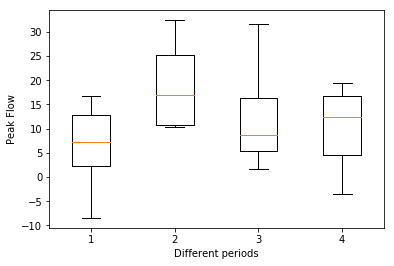

In [13]:
#Also make a boxplot for visualization
df1=df_anova[df_anova['treatments']==1]
df2=df_anova[df_anova['treatments']==2]
df3=df_anova[df_anova['treatments']==3]
df4=df_anova[df_anova['treatments']==4]

plt.boxplot((df1['Q12'],df2['Q12'],df3['Q12'],df4['Q12']))
plt.xlabel('Different periods')
plt.ylabel('Peak Flow')

## <font color = 'red'> According to the results shows above, period 1 is different from period 2 while other comparions are basically giving there is not significant change occurs.

## Problem 2

USGS gaged streamflow records for the Columbia River at The Dalles, OR began in 1878 and continues to the present day (one of the longest continuous records in the U.S.). Peak flow records (based on peak stage values recorded by railroad workers), however, extend back even farther, to 1858. Using coincident peak flow records from 1879-1932 (a period with no major storage dams on the Columbia):

A) First, isolate the period of relevant overlap (1879-1932) and plot the timeseries. Create a regression model for annual flow using spring peak flow as an explanatory variable.

In [14]:
import scipy.stats as st
import scipy.io as sio
import scipy.stats as st
%matplotlib inline

In [16]:
df=pd.read_excel('dalles_flow.xlsx')

In [37]:
#Rearrange the dataset

df_r=df.iloc[9:81,2:5].copy()
df_r.columns=['years','peakflow','annualmean']
df_r=df_r.reset_index()
df_r=pd.DataFrame(df_r,columns=['years','peakflow','annualmean'])
df_r=df_r.iloc[:54,:]
df_r.tail()

,years,peakflow,annualmean
49,1928,766000,243395
50,1929,460000,142389
51,1930,332000,142941
52,1931,308000,131230
53,1932,578000,200003


In [44]:
df_r['peakflow']=df_r['peakflow'].astype(int)
df_r['annualmean']=df_r['annualmean'].astype(int)

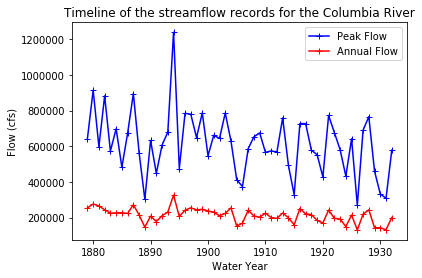

In [45]:
#First plot the data
plt.plot(df_r['years'],df_r['peakflow'],'b-+', label='Peak Flow');
plt.plot(df_r['years'],df_r['annualmean'],'r-+', label='Annual Flow');

plt.title('Timeline of the streamflow records for the Columbia River')
plt.xlabel('Water Year')
plt.ylabel('Flow (cfs)');
plt.legend(loc="best")

Text(0,0.5,'Annual Flow Mean (cfs)')

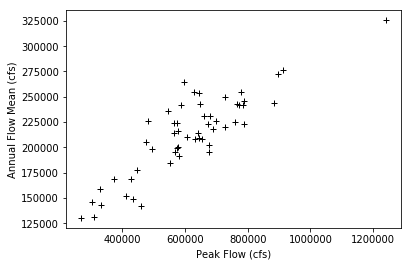

In [46]:
#Create scatter plot for the data

plt.plot(df_r['peakflow'],df_r['annualmean'],'k+')
plt.xlabel('Peak Flow (cfs)')
plt.ylabel('Annual Flow Mean (cfs)')

In [47]:
n = df_r['peakflow'].size
#According to the scatter plot we choose linear regression model to fit the data
Bv2 = np.polyfit(df_r['peakflow'],df_r['annualmean'],1)
print(Bv2)

x = np.linspace(np.min(df_r['peakflow']), np.max(df_r['peakflow']),n)
y = Bv2[1] + Bv2[0]*x

[1.97307224e-01 9.17957273e+04]


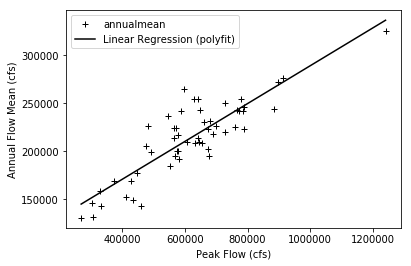

In [48]:
plt.plot(df_r['peakflow'],df_r['annualmean'],'k+')
plt.xlabel('Peak Flow (cfs)')
plt.ylabel('Annual Flow Mean (cfs)')
plt.plot(x,y,'k-',label='Linear Regression (polyfit)')
plt.legend()

B) How much of the variance is explained by the resulting model?

In [50]:
resid = df_r['annualmean'] - (Bv2[1] + Bv2[0]*(df_r['peakflow']))

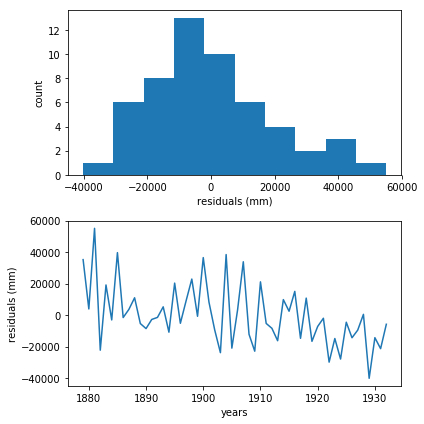

In [51]:
f, (ax1, ax2) = plt.subplots(2,1,figsize=(6,6))
ax1.hist(resid)
ax1.set_xlabel('residuals (mm)')
ax1.set_ylabel('count')


ax2.plot(df_r['years'],resid)
ax2.set_xlabel('years')
ax2.set_ylabel('residuals (mm)')

f.tight_layout()

In [55]:
#Calculate R P value from st.pearsonr()function
R, P = st.pearsonr(df_r['peakflow'],df_r['annualmean'])
print(R)
print(R*R)
print(P)

0.8712297880006823
0.7590413434997139
1.0707931769744675e-17


**Answer**

As the result shows, about 76% of variance were explained by the model.

C) Estimate the 95% confidence bounds for the annual flow estimates from 1858- 1877, and plot them with the central tendency (the prediction from the regression model).

In [ ]:
#create the subset for 1858-1877

D) Now create a non-parametric, quantile-based regression model using the same data.

E) Plot the predictions and residuals for the two different prediction models for the training period (1879-1932) and plot the model predictions for the pre-1878 data for the two different models. Is there a substantial difference between the two model formulations?